In [1]:
#IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram

#1. LOAD DATA

df = pd.read_excel("profiles-1.xlsx")

df_original = df.copy()

In [2]:
#2. CONTINUOUS NIGHTLIFE SCORE

#Encode the three variables columns as numbers (0,1,2,3,…)
for col in ["drinks", "smokes", "drugs"]:
    df[col] = df[col].astype("category").cat.codes

#make unknowns (-1) into 0
df[["drinks", "smokes", "drugs"]] = df[["drinks", "smokes", "drugs"]].dropna()

#Max code across the three
max_code = df[["drinks", "smokes", "drugs"]].to_numpy().max()
if max_code == 0:
    max_code = 1  #avoid division by zero just in case

#continuous versions: 0 -> 0.0, max_code -> 1.0
for col in ["drinks", "smokes", "drugs"]:
    df[col + "_c"] = df[col] / max_code

#Unhealthy score = sum of continuous versions
df["unhealthy_score"] = df["drinks_c"] + df["smokes_c"] + df["drugs_c"]

In [3]:
#3. INCOME & FEATURE

#fill missing income with median
df["income"] = pd.to_numeric(df["income"], errors="coerce")
df["income"] = df["income"].fillna(df["income"].median())

#X has 2 features: unhealthy_score (continuous), income
X = df[["unhealthy_score", "income"]].to_numpy().astype(float)

#Standardize for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

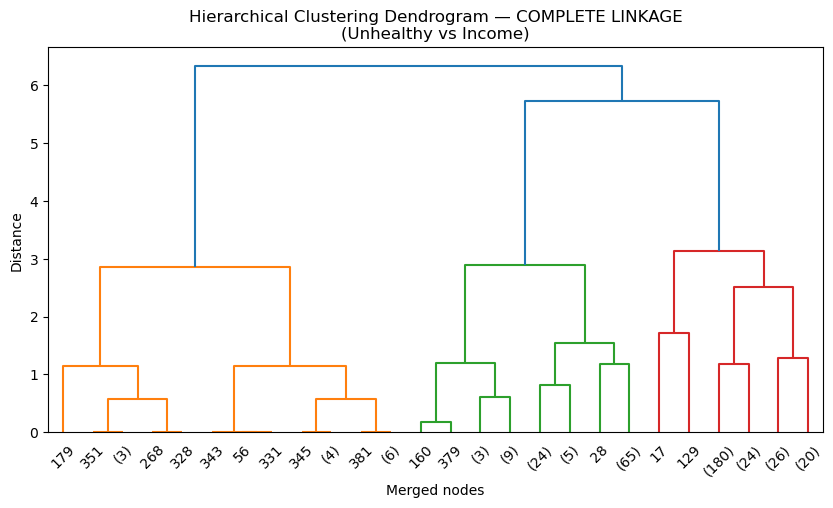

In [4]:
#4. DENDROGRAM (COMPLETE LINKAGE)

def plot_dendrogram(model, **kwargs):
    """Build linkage matrix from AgglomerativeClustering model and plot dendrogram."""
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        count = 0
        for child_idx in merge:
            if child_idx < n_samples:      #leaf node
                count += 1
            else:                          #previously merged node
                count += counts[child_idx - n_samples]
        counts[i] = count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

#full tree for dendrogram
tree_model = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage="complete",
    compute_distances=True
).fit(X_scaled)

plt.figure(figsize=(10, 5))
plt.title("Hierarchical Clustering Dendrogram — COMPLETE LINKAGE\n(Unhealthy vs Income)")
plot_dendrogram(tree_model, truncate_mode="level", p=4)
plt.xlabel("Merged nodes")
plt.ylabel("Distance")
plt.show()

In [5]:
#5. FINAL CLUSTERING

N_CLUSTERS = 4
cluster_model = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage="complete"
)
labels = cluster_model.fit_predict(X_scaled)

df["cluster"] = labels

cluster_names = {
    0: "Wild, Low-Income Individuals",
    1: "Chill, High-Income Individuals",
    2: "Chill, Low-Income Individuals",
    3: "Balanced and Social Outliers"
}
cluster_abbrevs = [
    "".join([ch if 65<=ord(ch)<=90 else "" for ch in name])
    for name in cluster_names.values()
]

df["cluster_name"] = df["cluster"].map(cluster_names)

print("Cluster counts:")
print(df["cluster"].value_counts().sort_index(), "\n")

Cluster counts:
cluster
0    109
1     22
2    250
3      2
Name: count, dtype: int64 



In [6]:
#6. CENTROIDS

centroids = df.groupby("cluster")[["unhealthy_score", "income"]].mean()
centroids['cluster_names'] = cluster_names.values()
print("Centroids in original (unhealthy, income) space:")
print(centroids, "\n")

Centroids in original (unhealthy, income) space:
         unhealthy_score          income                   cluster_names
cluster                                                                 
0               1.318807    54587.155963    Wild, Low-Income Individuals
1               0.931818  1000000.000000  Chill, High-Income Individuals
2               0.554000    69960.000000   Chill, Low-Income Individuals
3               0.375000   500000.000000    Balanced and Social Outliers 



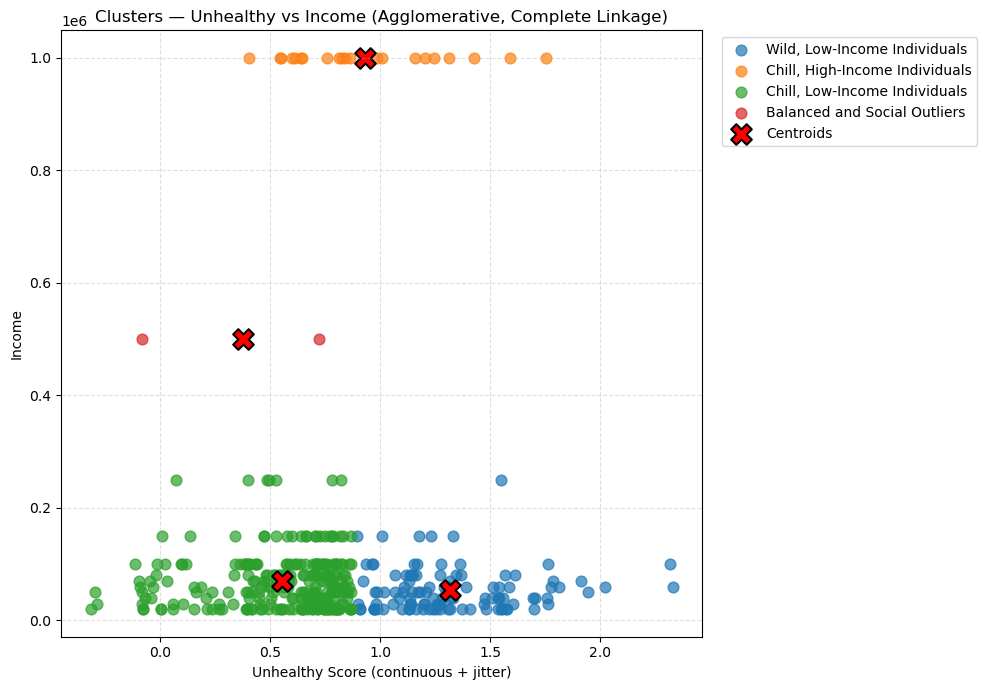

In [7]:
#7. SCATTER PLOT

#jitter unhealthy  so points don't overlap
jitter_strength = 0.12

plt.figure(figsize=(10, 7))

#plot each cluster with its names
for cluster_id, name in cluster_names.items():
    group = df[df["cluster"] == cluster_id]

    plt.scatter(
        group["unhealthy_score"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(group)),
        group["income"],
        label=name,
        alpha=0.7,
        s=60
    )

#plot centroids
plt.scatter(
    centroids["unhealthy_score"],
    centroids["income"],
    marker="X",
    s=220,
    c="red",
    edgecolors="black",
    linewidths=1.5,
    label="Centroids"
)

plt.xlabel("Unhealthy Score (continuous + jitter)")
plt.ylabel("Income")
plt.title("Clusters — Unhealthy vs Income (Agglomerative, Complete Linkage)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

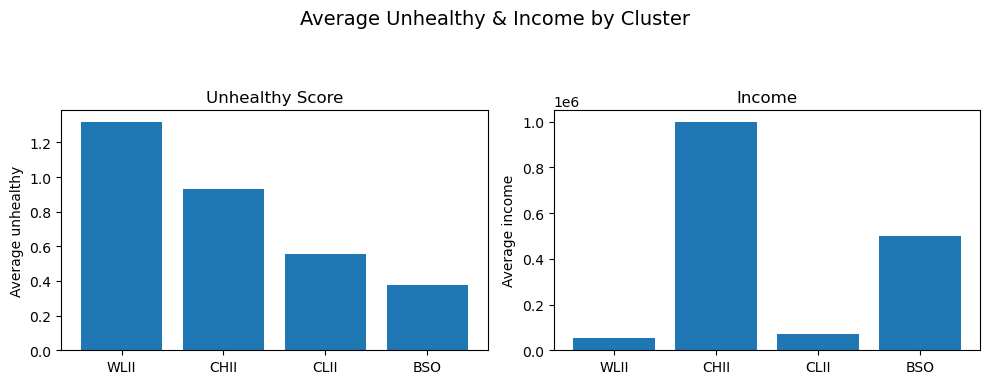

In [8]:
#8. BAR GRAPHS OF CENTROIDS

cluster_labels = cluster_abbrevs

plt.figure(figsize=(10, 4))
plt.suptitle("Average Unhealthy & Income by Cluster", fontsize=14)

plt.subplot(1, 2, 1)
plt.bar(cluster_labels, centroids["unhealthy_score"])
plt.title("Unhealthy Score")
plt.ylabel("Average unhealthy")

plt.subplot(1, 2, 2)
plt.bar(cluster_labels, centroids["income"])
plt.title("Income")
plt.ylabel("Average income")

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()